In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
# Importing Data
df = pd.read_excel("C:\\Users\\mcado\\OneDrive\\Documents\\Online Retail.xlsx")

In [3]:
# Looking at the first 5 rows to see how data is structured
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Go to see how many of values of each column there are.

df.nunique()


InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [5]:
# Taking a closer look at country column to make sure spelling is consistent.
df["Country"].value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [6]:
def clean_retail(df):
    df = df.copy()
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    # Remove credit notes
    df = df[~df["InvoiceNo"].astype(str).str.startswith('C', na=False)]
    # Drop missing CustomerID (can't do RFM without)
    df = df.dropna(subset=["CustomerID"])
    # Keep positive qty & price
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
    # Line revenue
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
    return df

In [7]:
def make_rfm(df):
    snapshot_date = df["InvoiceDate"].max() + timedelta(days=1)
    rfm = (
        df.groupby("CustomerID")
          .agg(
              recency_days=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
              frequency_invoices=("InvoiceNo", "nunique"),
              monetary_total=("TotalPrice", "sum")
          )
          .reset_index()
    )
    return rfm

In [8]:
def scale_features(rfm, cols):
    rfm_scaled = rfm.copy()
    # log-transform skewed vars
    rfm_scaled[["frequency_invoices", "monetary_total"]] = np.log1p(
        rfm_scaled[["frequency_invoices", "monetary_total"]]
    )
    scaler = StandardScaler()
    X = scaler.fit_transform(rfm_scaled[cols])
    return X, scaler

def choose_k(X, k_min=2, k_max=10, random_state=42):
    best_k, best_score = None, -1
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = km.fit_predict(X)
        # need at least 2 labels for silhouette
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_k, best_score = k, score
    return best_k, best_score

def fit_kmeans(X, k, random_state=42):
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    labels = km.fit_predict(X)
    return km, labels

In [9]:
def cluster_profile(rfm_with_clusters):
    prof = (
        rfm_with_clusters
        .groupby("cluster")
        .agg(
            n_customers=("CustomerID", "count"),
            recency_days_mean=("recency_days", "mean"),
            frequency_invoices_mean=("frequency_invoices", "mean"),
            monetary_total_mean=("monetary_total", "mean"),
            recency_days_median=("recency_days", "median"),
            frequency_invoices_median=("frequency_invoices", "median"),
            monetary_total_median=("monetary_total", "median")
        )
        .round(2)
        .sort_values("monetary_total_mean", ascending=False)
    )
    return prof

In [10]:
def plot_clusters_pca(X, labels, title="Clusters (PCA 2D)"):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=25, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(*scatter.legend_elements(), title="cluster", loc="best")
    plt.tight_layout()
    plt.show()



In [11]:
def plot_clusters_rfm(rfm):
    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(
        np.log1p(rfm["frequency_invoices"]),
        np.log1p(rfm["monetary_total"]),
        c=rfm["cluster"],
        s=25,
        alpha=0.7
    )
    plt.xlabel("log1p(Frequency)")
    plt.ylabel("log1p(Monetary)")
    plt.title("Clusters on RFM (log scales)")
    plt.legend(*scatter.legend_elements(), title="cluster", loc="best")
    plt.tight_layout()
    plt.show()

In [12]:
def segment_customers(df, k_range=(2, 10), plot=True):
    df_clean = clean_retail(df)
    rfm = make_rfm(df_clean)

    feature_cols = ["recency_days", "frequency_invoices", "monetary_total"]
    X, scaler = scale_features(rfm, feature_cols)

    best_k, best_sil = choose_k(X, k_min=k_range[0], k_max=k_range[1])
    print(f"Best k (silhouette): {best_k} (score={best_sil:.3f})")

    km, labels = fit_kmeans(X, best_k)
    rfm["cluster"] = labels

    prof = cluster_profile(rfm)

    if plot:
        plot_clusters_pca(X, labels)
        plot_clusters_rfm(rfm)

    return rfm, prof, km, scaler, X, labels

C:\Users\mcado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\mcado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\mcado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\Users\mcado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

Best k (silhouette): 3 (score=0.416)


C:\Users\mcado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


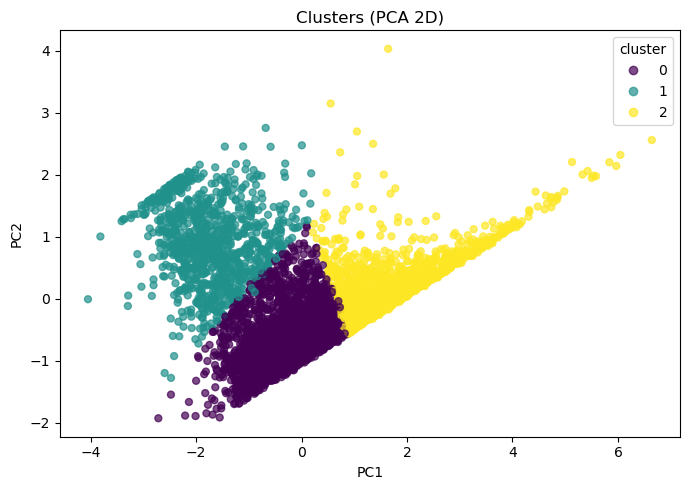

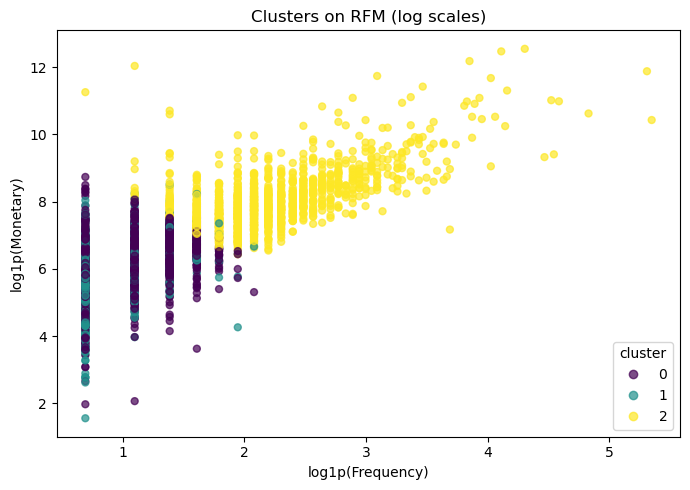

(      CustomerID  recency_days  frequency_invoices  monetary_total  cluster
 0        12346.0           326                   1        77183.60        2
 1        12347.0             2                   7         4310.00        2
 2        12348.0            75                   4         1797.24        2
 3        12349.0            19                   1         1757.55        0
 4        12350.0           310                   1          334.40        1
 ...          ...           ...                 ...             ...      ...
 4333     18280.0           278                   1          180.60        1
 4334     18281.0           181                   1           80.82        1
 4335     18282.0             8                   2          178.05        0
 4336     18283.0             4                  16         2094.88        2
 4337     18287.0            43                   3         1837.28        0
 
 [4338 rows x 5 columns],
          n_customers  recency_days_mean  freque

In [13]:
segment_customers(df)

Based on RFM graph:***Cluster 2 this would be the high value or loyalty customers. They order more and 
***Cluster 0 would be the medium value customers. 
Cluster 1 would be the occasional shopper